# Problem Statement

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

# Data

Our overall collection of tweets was split in the ratio of 65:35 into training and testing data. Out of the testing data, 30% is public and the rest is private.

# Data Aquisition

In [1]:
# Importing necessary Packages
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv('./Hate_Speech_train.csv')

In [3]:
test_data = pd.read_csv('./Hate_Speech_test.csv')

In [4]:
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
data['tweet'].head()

0     @user when a father is dysfunctional and is s...
1    @user @user thanks for #lyft credit i can't us...
2                                  bihday your majesty
3    #model   i love u take with u all the time in ...
4               factsguide: society now    #motivation
Name: tweet, dtype: object

In [6]:
def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

# Text Cleaning

Text Cleaning involves 4 major steps:

1) Lowering the entire text

2) Removing Punctuations

3) Removing Stopwords

4) Normalizing the text

In [7]:
# Using Word Lemmatizer
lemm = WordNetLemmatizer()

def cleaning(text):
    # Lowering the entire text
    lower = text.lower()
    
    # Removing Punctuations
    punctuations = string.punctuation
    no_punc = "".join(char for char in lower if char not in punctuations)
    
    # Removing Stopword
    words = no_punc.split()
    stopwords_list = stopwords.words('english')
    no_stop = [word for word in words if word not in stopwords_list]
    
    # Lemmatization or Normalization
    cleaned = [lemm.lemmatize(word,'v') for word in no_stop]
    
    # Join
    cleaned_text = ' '.join(cleaned)
    return cleaned_text
    
    

In [8]:
comb_data = data.append(test_data, ignore_index=True)

In [9]:
comb_data['tidy_tweet'] = comb_data['tweet'].apply(lambda x: preprocess(x))

In [10]:
comb_data.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [11]:
comb_data['tidy_tweet'] = comb_data['tidy_tweet'].apply(lambda x: cleaning(x))

In [12]:
comb_data['tidy_tweet'] = comb_data['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

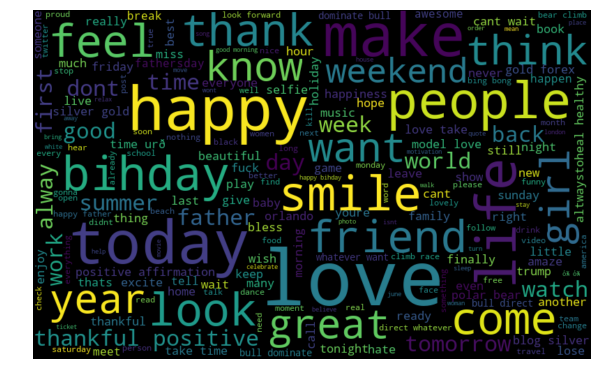

In [13]:
all_words = ' '.join([text for text in comb_data['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

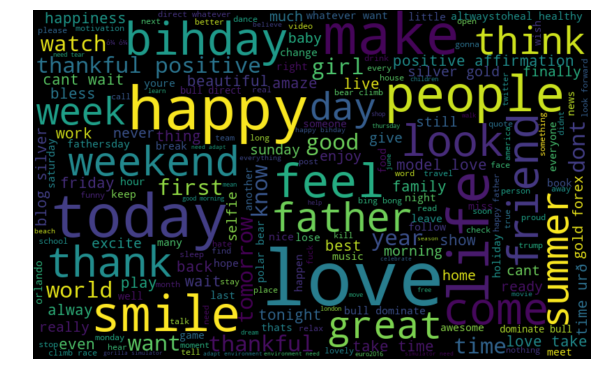

In [14]:
normal_words =' '.join([text for text in comb_data['tidy_tweet'][comb_data['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

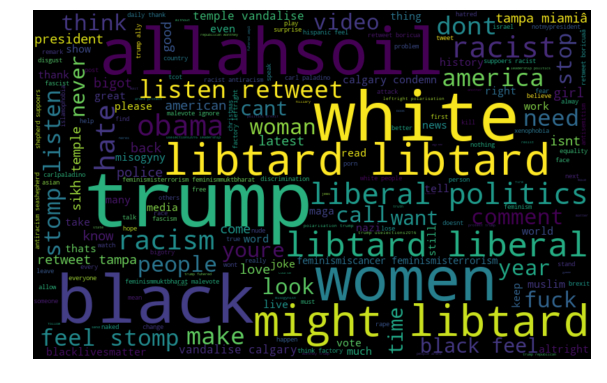

In [15]:
normal_words =' '.join([text for text in comb_data['tidy_tweet'][comb_data['label'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [16]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

# Feature Engineering

## Count Features

In [17]:
# Word count before cleaning
comb_data['word_count'] = comb_data['tweet'].apply(lambda x : len(x.split()))

In [18]:
# Word count after cleaning
comb_data['word_count_clean'] = comb_data['tidy_tweet'].apply(lambda x: len(x.split()))

In [19]:
comb_data['char_count'] = comb_data['tidy_tweet'].apply(lambda x: len(x.replace(' ','')))

In [20]:
comb_data.head()

,id,label,tweet,tidy_tweet,word_count,word_count_clean,char_count
0,1,0.0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag dysfunction,18,5,41
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank lyft credit cant cause dont offer wheelc...,19,11,68
2,3,0.0,bihday your majesty,bihday majesty,3,2,13
3,4,0.0,#model i love u take with u all the time in ...,model love take time urð± ðððð ð...,14,7,50
4,5,0.0,factsguide: society now #motivation,factsguide society motivation,4,3,27


## PoS counting

In [21]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

In [22]:
# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(txt, flag):
    tags = nltk.pos_tag(nltk.word_tokenize(txt))
    count = 0
    for tag in tags:
        tag = tag[1]
        if tag in pos_family[flag]:
            count += 1 
    return count

In [23]:
comb_data['noun_count'] = comb_data['tweet'].apply(lambda x: check_pos_tag(x, 'noun'))
comb_data['verb_count'] = comb_data['tweet'].apply(lambda x: check_pos_tag(x, 'verb'))
comb_data['adj_count'] = comb_data['tweet'].apply(lambda x: check_pos_tag(x, 'adj'))
comb_data['adv_count'] = comb_data['tweet'].apply(lambda x: check_pos_tag(x, 'adv'))
comb_data['pron_count'] = comb_data['tweet'].apply(lambda x: check_pos_tag(x, 'pron'))

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer 

In [81]:
tfidf =TfidfVectorizer(max_features=5000,ngram_range=(1,3))
tfidf.fit(comb_data["tidy_tweet"].values)
tfidf = tfidf.transform(comb_data["tidy_tweet"].values)

In [82]:
#data = data.drop(['tfidf'],axis=1)
comb_data.head()

,id,label,tweet,tidy_tweet,word_count,word_count_clean,char_count,noun_count,verb_count,adj_count,adv_count,pron_count
0,1,0.0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag dysfunction,18,5,41,5,4,2,2,3
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank lyft credit cant cause dont offer wheelc...,19,11,68,9,5,3,2,1
2,3,0.0,bihday your majesty,bihday majesty,3,2,13,1,0,0,1,1
3,4,0.0,#model i love u take with u all the time in ...,model love take time urð± ðððð ð...,14,7,50,5,1,4,0,0
4,5,0.0,factsguide: society now #motivation,factsguide society motivation,4,3,27,3,0,0,1,0


In [83]:
from scipy.sparse import hstack, csr_matrix

meta_features = ['word_count', 'word_count_clean',
       'char_count', 'noun_count', 'verb_count', 'adj_count', 'adv_count',
       'pron_count']

feature_set1 = comb_data[meta_features]

train = hstack([tfidf, csr_matrix(feature_set1)], "csr")
train

<49159x5008 sparse matrix of type '<class 'numpy.float64'>'
	with 619314 stored elements in Compressed Sparse Row format>

In [84]:
train,test = train[:len(data)],train[len(data):]

In [85]:
from sklearn.preprocessing import LabelEncoder 

target = data["label"].values
target = LabelEncoder().fit_transform(target)

In [86]:
target

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [87]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(train, target)

In [88]:
train_x.shape

(23971, 5008)

In [89]:
val_x.shape

(7991, 5008)

In [90]:
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn import ensemble
from sklearn.metrics import accuracy_score

In [91]:
model1 = naive_bayes.MultinomialNB()
model1.fit(train_x, train_y)
preds1 = model1.predict(val_x)
accuracy_score(preds1, val_y)

0.9403078463271181

In [92]:
from sklearn.metrics import f1_score

In [93]:
f1_score(preds1,val_y)

0.321479374110953

In [94]:
model2 = LogisticRegression()
model2.fit(train_x, train_y)
preds2 = model2.predict(val_x)
accuracy_score(preds2, val_y)

0.9486922788136654

In [95]:
f1_score(preds2,val_y)

0.48101265822784806

In [70]:
model3 = svm.SVC()
model3.fit(train_x, train_y)
preds3 = model3.predict(val_x)
accuracy_score(preds3, val_y)

0.9317982730571893

In [71]:
f1_score(preds3,val_y)

C:\Users\Sree Vasthav S V\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.0

In [72]:
import xgboost

In [73]:
model4 = xgboost.XGBClassifier()
model4.fit(train_x, train_y)
preds4 = model4.predict(val_x)
accuracy_score(preds4, val_y)

C:\Users\Sree Vasthav S V\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9435615066950319

In [74]:
f1_score(preds4,val_y)

0.3114503816793893

In [75]:
from sklearn.metrics import precision_score,recall_score

In [96]:
model = model2

In [97]:
preds = model.predict(test)

In [98]:
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [100]:
out = pd.DataFrame({'id': test_data['id'],'label':preds},index=None)

In [101]:
out.to_csv('./OutputV5.csv')

In [104]:
# load the pre-trained word-embedding vectors
import numpy as np 
embeddings_index = {}
for i, line in enumerate(open('pretrained.vec', encoding="utf8")):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

In [105]:
# create a tokenizer 
from keras.preprocessing import text, sequence
from sklearn import model_selection 

token = text.Tokenizer()
token.fit_on_texts(data['tweet'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(data['tweet'], target)
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [106]:
train_x.shape

(23971,)

In [112]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return accuracy_score(predictions, valid_y)

In [113]:
from keras import layers , models , optimizers
from sklearn import metrics

def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("CNN, Word Embeddings", accuracy)

Epoch 1/1
23971/23971 [==============================] - 13s 559us/step - loss: 0.1643
CNN, Word Embeddings 0.9292954573895632


In [114]:

token = text.Tokenizer()
token.fit_on_texts(test_data['tweet'])
word_index = token.word_index

In [116]:
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(test_data['tweet']), maxlen=70)

In [128]:
predictions = classifier.predict(test_seq_x)

In [129]:
predictions

array([[0.6587597 ],
       [0.00508729],
       [0.01309326],
       ...,
       [0.01823614],
       [0.00156193],
       [0.00087319]], dtype=float32)

In [130]:
predictions = np.where(predictions > 0.5 , 1 , 0)

In [134]:
preds = predictions.ravel()

In [135]:
preds

array([1, 0, 0, ..., 0, 0, 0])

In [136]:
out = pd.DataFrame({'id': test_data['id'],'label':preds},index=None)

In [137]:
out.to_csv('./OutputV6.csv')

In [138]:
predictions.sum()

360